In [ ]:
import pandas as pd
import json
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.arima.model import ARIMA

In [11]:
file_path = 'eos_final_cleaned.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

df = pd.DataFrame(data)
df.head()

,title,president,publication_date,signing_date,citation,document_number,executive_order_number,pdf_url,toc_subject,disposition_notes,cleaned_text
0,Combating Emerging Firearms Threats and Improv...,"{'identifier': 'joe-biden', 'name': 'Joseph R....",2024-10-02,2024-09-26,89 FR 80345,2024-22938,14127,https://www.govinfo.gov/content/pkg/FR-2024-10...,None,None,Executive Order 14127--Combating Emerging Fire...
1,Investing in America and Investing in American...,"{'identifier': 'joe-biden', 'name': 'Joseph R....",2024-09-11,2024-09-06,89 FR 73559,2024-20712,14126,https://www.govinfo.gov/content/pkg/FR-2024-09...,Federal Government:,"See: EO 11246, September 24, 1965; EO 13985, J...","Executive Order 14126 of September 6, 2024 Inv..."
2,Establishing an Emergency Board To Investigate...,"{'identifier': 'joe-biden', 'name': 'Joseph R....",2024-07-29,2024-07-24,89 FR 60791,2024-16740,14125,https://www.govinfo.gov/content/pkg/FR-2024-07...,"Committees; Establishment, Renewal, Terminatio...",None,"Executive Order 14125 of July 24, 2024 Establi..."
3,White House Initiative on Advancing Educationa...,"{'identifier': 'joe-biden', 'name': 'Joseph R....",2024-07-22,2024-07-17,89 FR 59585,2024-16225,14124,https://www.govinfo.gov/content/pkg/FR-2024-07...,Education:,"See: EO 14045, September 13, 2021",Executive Order 14124--White House Initiative ...
4,White House Council on Supply Chain Resilience,"{'identifier': 'joe-biden', 'name': 'Joseph R....",2024-06-21,2024-06-14,89 FR 51949,2024-13810,14123,https://www.govinfo.gov/content/pkg/FR-2024-06...,"Committees; Establishment, Renewal, Terminatio...","See: EO 14017, February 24, 2021 Supersedes: E...","Executive Order 14123 of June 14, 2024 White H..."


In [12]:
# some clean before analyzing 

df['president_name'] = df['president'].apply(lambda x: x['name'] if isinstance(x, dict) else x)

df = df.drop(columns=['president'])
df.head()

,title,publication_date,signing_date,citation,document_number,executive_order_number,pdf_url,toc_subject,disposition_notes,cleaned_text,president_name
0,Combating Emerging Firearms Threats and Improv...,2024-10-02,2024-09-26,89 FR 80345,2024-22938,14127,https://www.govinfo.gov/content/pkg/FR-2024-10...,None,None,Executive Order 14127--Combating Emerging Fire...,Joseph R. Biden Jr.
1,Investing in America and Investing in American...,2024-09-11,2024-09-06,89 FR 73559,2024-20712,14126,https://www.govinfo.gov/content/pkg/FR-2024-09...,Federal Government:,"See: EO 11246, September 24, 1965; EO 13985, J...","Executive Order 14126 of September 6, 2024 Inv...",Joseph R. Biden Jr.
2,Establishing an Emergency Board To Investigate...,2024-07-29,2024-07-24,89 FR 60791,2024-16740,14125,https://www.govinfo.gov/content/pkg/FR-2024-07...,"Committees; Establishment, Renewal, Terminatio...",None,"Executive Order 14125 of July 24, 2024 Establi...",Joseph R. Biden Jr.
3,White House Initiative on Advancing Educationa...,2024-07-22,2024-07-17,89 FR 59585,2024-16225,14124,https://www.govinfo.gov/content/pkg/FR-2024-07...,Education:,"See: EO 14045, September 13, 2021",Executive Order 14124--White House Initiative ...,Joseph R. Biden Jr.
4,White House Council on Supply Chain Resilience,2024-06-21,2024-06-14,89 FR 51949,2024-13810,14123,https://www.govinfo.gov/content/pkg/FR-2024-06...,"Committees; Establishment, Renewal, Terminatio...","See: EO 14017, February 24, 2021 Supersedes: E...","Executive Order 14123 of June 14, 2024 White H...",Joseph R. Biden Jr.


In [ ]:
# EDA
# distribution of the president_name column
president_counts = df['president_name'].value_counts()

# distribution of executive order numbers
eo_summary = df['executive_order_number'].describe()

# date distribution and potential time trends
df['publication_date'] = pd.to_datetime(df['publication_date'])
df['signing_date'] = pd.to_datetime(df['signing_date'])
df['publication_year'] = df['publication_date'].dt.year
annual_orders = df.groupby('publication_year').size()

president_counts, eo_summary, annual_orders.head()


(president_name
 William J. Clinton     306
 Barack Obama           294
 George W. Bush         294
 Donald Trump           221
 Joseph R. Biden Jr.    143
 Name: count, dtype: int64,
 count      1236
 unique     1234
 top       13526
 freq          2
 Name: executive_order_number, dtype: object,
 publication_year
 1994    50
 1995    42
 1996    50
 1997    38
 1998    38
 dtype: int64)

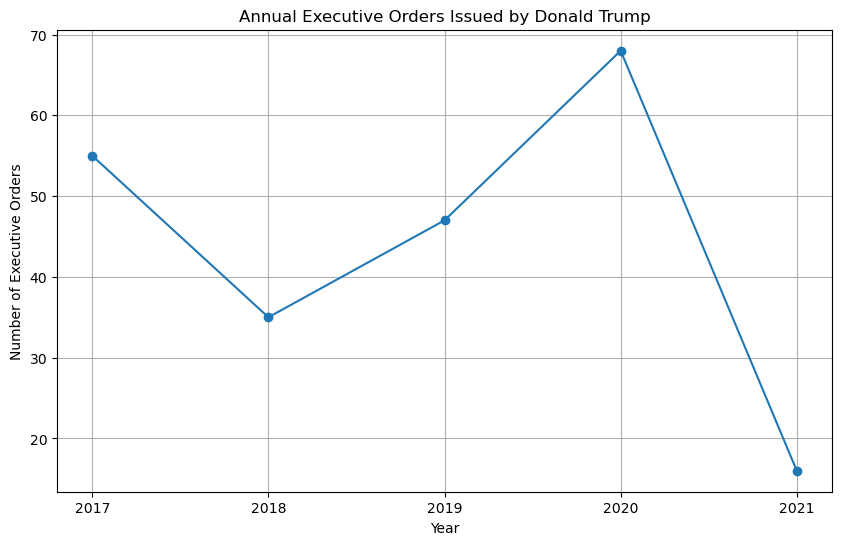

In [ ]:
# only focus on trump 
trump_data = df[df['president_name'] == "Donald Trump"]
trump_annual_orders = trump_data.groupby(trump_data['publication_date'].dt.year).size()

plt.figure(figsize=(10, 6))
plt.plot(trump_annual_orders.index, trump_annual_orders.values, marker='o')
plt.title("Annual Executive Orders Issued by Donald Trump")
plt.xlabel("Year")
plt.ylabel("Number of Executive Orders")
plt.xticks(trump_annual_orders.index)
plt.grid(True)
plt.show()


since trump will be the president for next term, so I am interesting to see how trump perform on executive order during his term from 2017-2021 that probably could give us some ideas of how he will perform in his present term. 

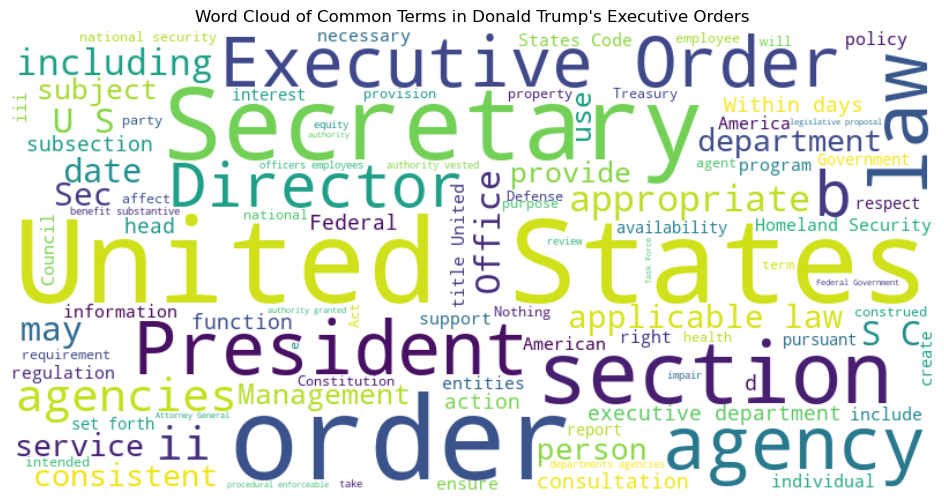

array(['executive', 'federal', 'law', 'order', 'sec', 'secretary',
       'section', 'shall', 'states', 'united'], dtype=object)

In [ ]:
# focus on cleaned text for Donald Trump
trump_text_data = trump_data['cleaned_text']

# Generate a word cloud to visualize common terms in Trump's executive orders
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(trump_text_data))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Common Terms in Donald Trump's Executive Orders")
plt.show()

# TF-IDF analysis: Top terms based on TF-IDF scores
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = vectorizer.fit_transform(trump_text_data)
top_terms = vectorizer.get_feature_names_out()

top_terms


as we can see that top frequency words are united states, secretary,, agency, executive order, director, order, etc. these words seems irrelevant for us to determine the topic or trends on trump orders. So let do deep cleaning on text

In [ ]:
# Define additional stopwords to remove
custom_stopwords = [
    'united', 'states', 'president', 'executive', 'order', 'secretary','ii','appropriate'
    'agencies', 'agency', 'department', 'federal', 'shall', 'section', 'sec','including'
]

def clean_text(text):
    # Remove custom stopwords
    text = text.lower()
    words = text.split()
    words = [word for word in words if word.lower() not in custom_stopwords]
    # Join words back into a single string
    cleaned_text = ' '.join(words)
    # Remove any non-alphabetic characters left
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    return cleaned_text

# apply the cleaning function to the cleaned_text column
df['refined_text'] = df['cleaned_text'].apply(clean_text)

# Display the refined text for a few entries
df[['cleaned_text', 'refined_text']].head()


,cleaned_text,refined_text
0,Executive Order 14127--Combating Emerging Fire...,combating emerging firearms threats and improv...
1,"Executive Order 14126 of September 6, 2024 Inv...",of september investing in america and inves...
2,"Executive Order 14125 of July 24, 2024 Establi...",of july establishing an emergency board to ...
3,Executive Order 14124--White House Initiative ...,white house initiative on advancing educationa...
4,"Executive Order 14123 of June 14, 2024 White H...",of june white house council on supply chain...


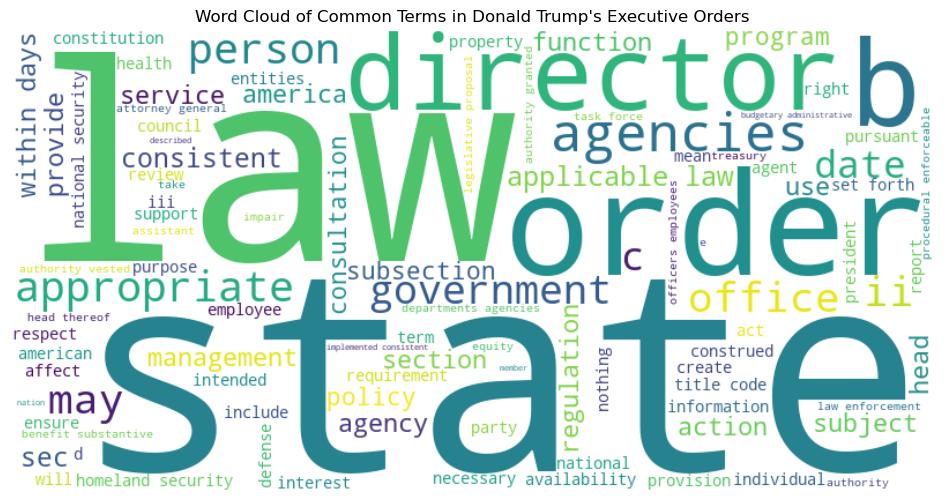

array(['agencies', 'appropriate', 'director', 'law', 'national', 'order',
       'person', 'sec', 'security', 'states'], dtype=object)

In [ ]:
# let do wordcloud again to see if any improvement

df['refined_text'] = df['cleaned_text'].apply(clean_text)
trump_refined_text = df[df['president_name'] == "Donald Trump"]['refined_text']
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(trump_refined_text))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Common Terms in Donald Trump's Executive Orders")
plt.show()

vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = vectorizer.fit_transform(trump_refined_text)
top_terms = vectorizer.get_feature_names_out()

top_terms

after performing wordcloud, it's hard to see the top frequency words and TF-IDF scores' result is also hard to see the insight. Therefore, we move to next step - topic modeling on trump's order, it will return five most relevant topics. 

In [ ]:
# Vectorize the text data for topic modeling
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
trump_text_counts = count_vectorizer.fit_transform(trump_refined_text)

# Fit the LDA model on refined text
lda_refined = LatentDirichletAllocation(n_components=5, random_state=42)
lda_refined.fit(trump_text_counts)

# Display top words for each topic based on refined text
n_top_words = 10
words_refined = count_vectorizer.get_feature_names_out()
refined_topics = {}

for topic_idx, topic in enumerate(lda_refined.components_):
    top_words = [words_refined[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    refined_topics[f"Topic {topic_idx + 1}"] = top_words
# to better print out result
from pprint import pprint
pprint(refined_topics)


{'Topic 1': ['health',
             'committee',
             'patients',
             'services',
             'healthcare',
             'medicare',
             'americans',
             'care',
             'access',
             'order'],
 'Topic 2': ['title',
             'order',
             'code',
             'act',
             'usc',
             'service',
             'appropriate',
             'consistent',
             'public',
             'director'],
 'Topic 3': ['order',
             'foreign',
             'property',
             'state',
             'pursuant',
             'national',
             'security',
             'government',
             'persons',
             'act'],
 'Topic 4': ['order',
             'appropriate',
             'security',
             'policy',
             'national',
             'director',
             'consistent',
             'infrastructure',
             'days',
             'use'],
 'Topic 5': ['council',
           

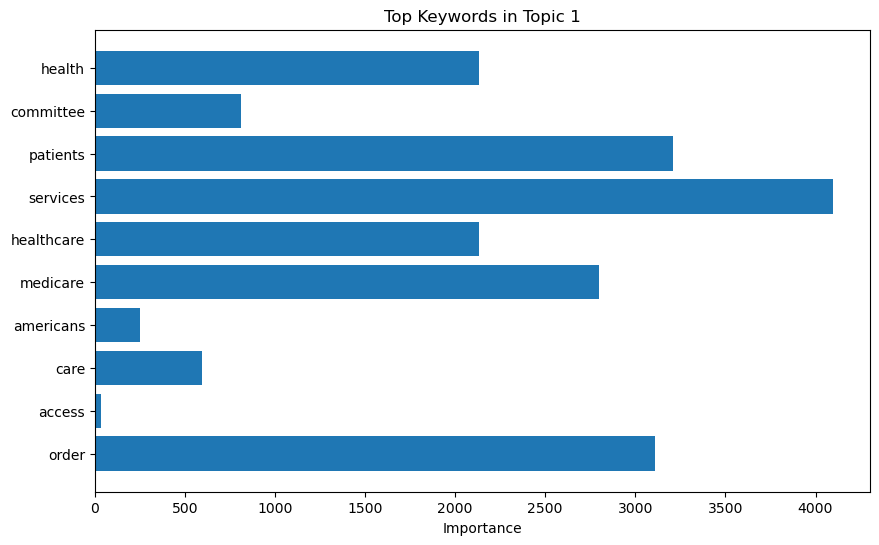

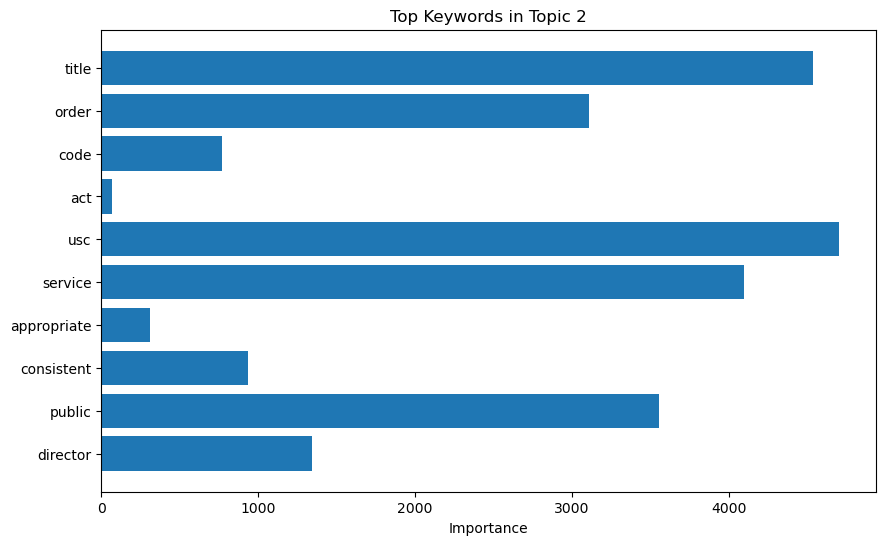

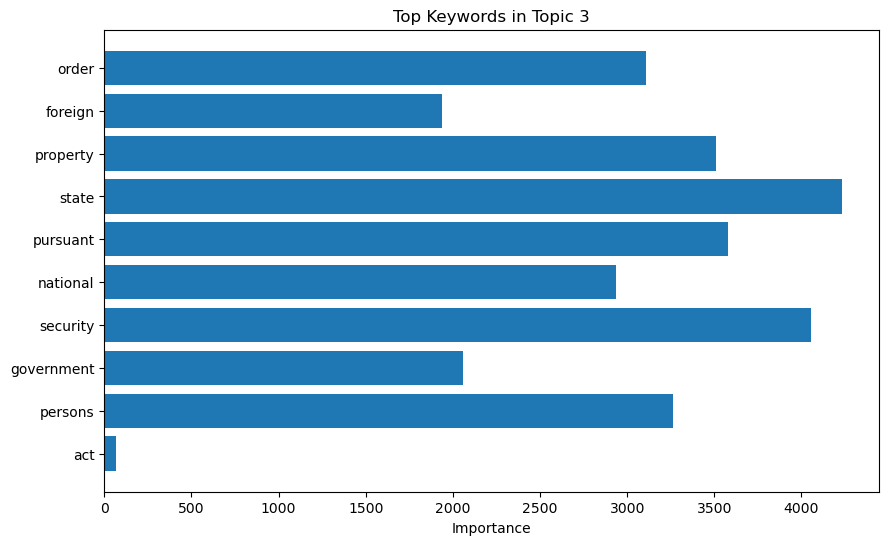

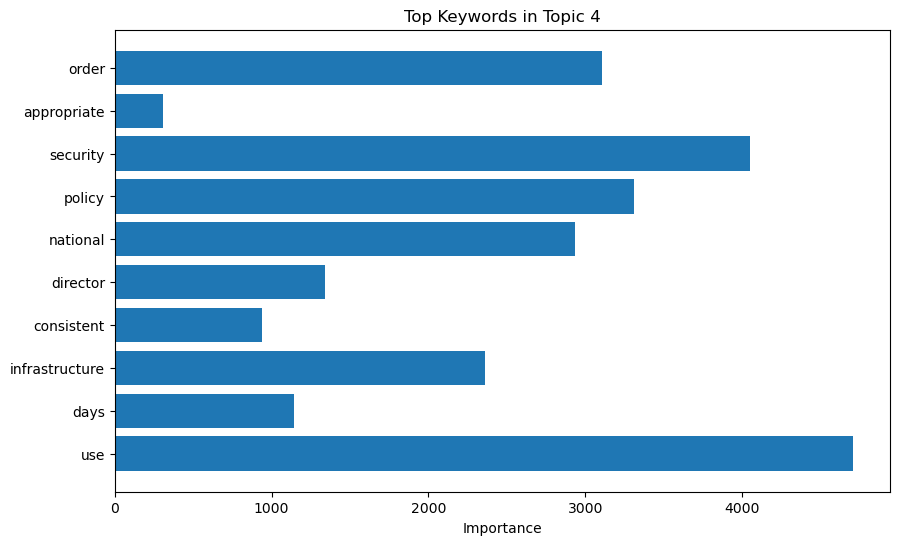

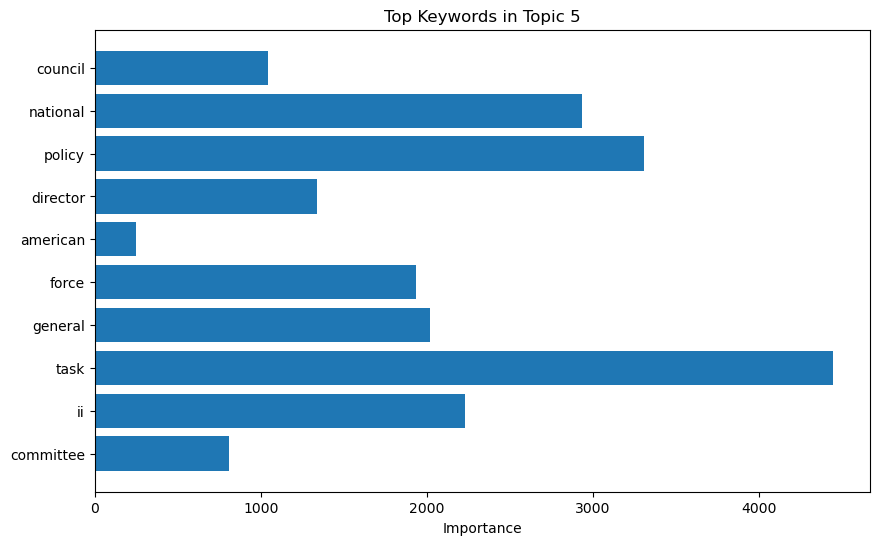

In [ ]:
# bar chart of top words per topic that allows to display the top words in each
# topic along with their relative importance

for topic_idx, top_words in refined_topics.items():
    plt.figure(figsize=(10, 6))
    plt.barh(top_words, lda_refined.components_[int(topic_idx.split()[-1]) - 1].argsort()[:-n_top_words - 1:-1])
    plt.gca().invert_yaxis()  # Invert y-axis to have the top keyword at the top
    plt.title(f"Top Keywords in {topic_idx}")
    plt.xlabel("Importance")
    plt.show()



Topic 1: Healthcare and Access:
Keywords such as "health," "patients," "services," and "medicare" suggest a focus on policies related to healthcare access, affordability, and patient rights. This topic likely covers initiatives aimed at reforming or enhancing healthcare services for Americans, potentially including healthcare infrastructure and cost management.

Topic 2: Legal and Administrative References:
Terms like "title," "code," "act," and "usc" (United States Code) indicate that this topic is more administrative and procedural. It likely involves legal frameworks and regulatory compliance, possibly encompassing orders that establish or modify specific legal provisions.

Topic 3: Foreign Affairs and Security:
With words like "foreign," "property," "state," and "national," this topic centers on international relations and national security. The frequent appearance of "property" and "pursuant" suggests these orders may address issues such as foreign-owned assets in the U.S., sanctions, and the protection of U.S. interests abroad.

Topic 4: National Security and Policy:
This topic includes terms such as "security," "policy," "national," and "director," highlighting directives related to the overall security strategy and domestic policy adjustments. Orders in this area likely address strategic responses to internal security threats and involve multiple agencies and interagency coordination.

Topic 5: National Councils and Task Forces:
Keywords like "council," "director," "policy," and "task" point to executive orders that set up or modify national councils and task forces. This focus area suggests efforts to establish coordinated approaches to tackle key issues, likely involving specialized teams for policy implementation, particularly in areas of national priority

C:\Users\xgygr\AppData\Local\Temp\ipykernel_13396\4048719726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_data['month_year'] = trump_data['publication_date'].dt.to_period('M')


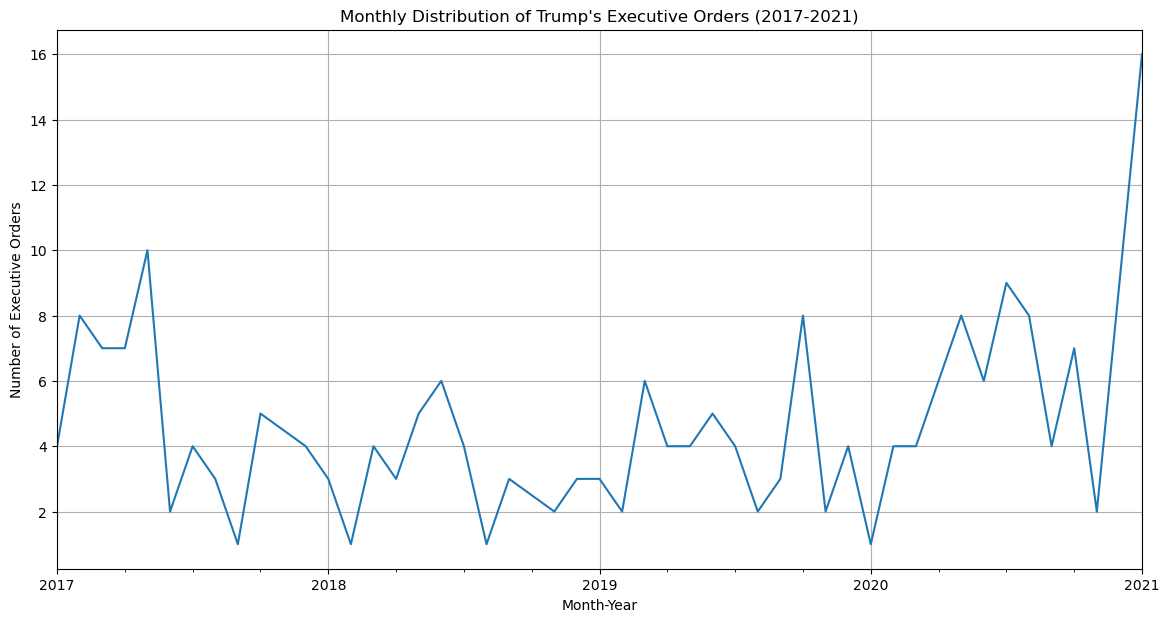

In [41]:
# based on his previous terms, we would like to forcast the humber of executive order
# trump might publish on year 2025-2026

trump_data['month_year'] = trump_data['publication_date'].dt.to_period('M')
monthly_orders = trump_data.groupby('month_year').size()

plt.figure(figsize=(14, 7))
monthly_orders.plot()
plt.title("Monthly Distribution of Trump's Executive Orders (2017-2021)")
plt.xlabel("Month-Year")
plt.ylabel("Number of Executive Orders")
plt.grid(True)
plt.show()

c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

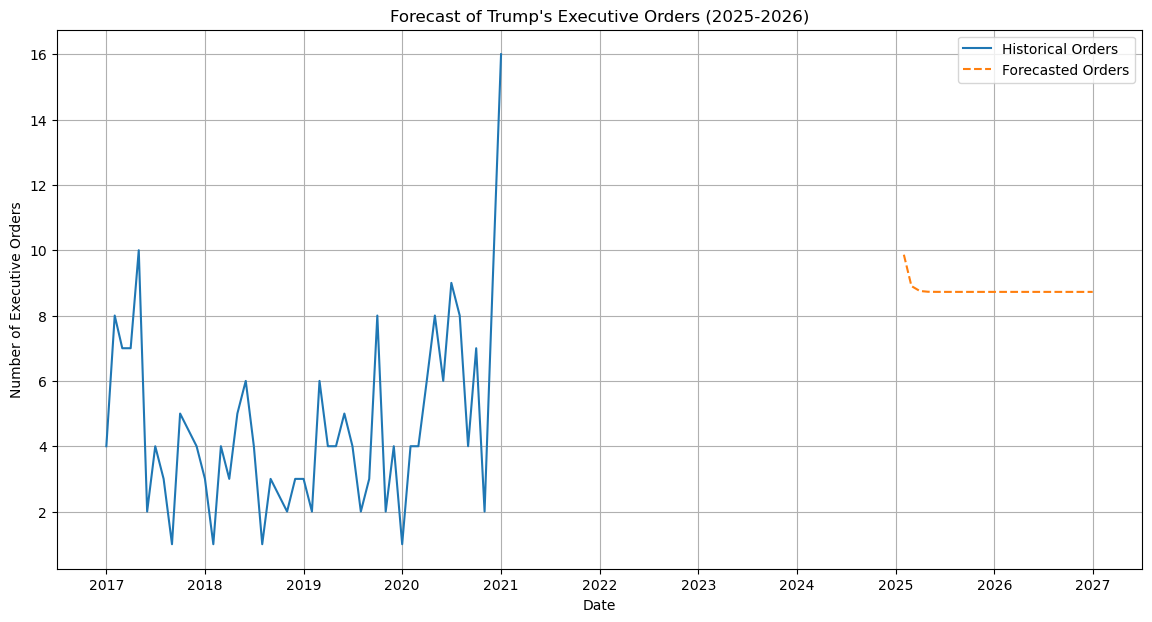

47    9.862621
48    8.902510
49    8.752313
50    8.728817
51    8.725141
52    8.724566
Name: predicted_mean, dtype: float64

In [ ]:
# Convert the monthly_orders index to datetime format for ARIMA modeling
monthly_orders.index = monthly_orders.index.to_timestamp()

# Fit an ARIMA model to the monthly data
# Choosing an initial order (p,d,q) based on general ARIMA practices; can be fine-tuned
arima_model = ARIMA(monthly_orders, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast the number of executive orders for 24 future months (2 years from 2025)
forecast_steps = 24
forecast = arima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2025-01-01', periods=forecast_steps, freq='M')
forecast_values = forecast.predicted_mean

plt.figure(figsize=(14, 7))
plt.plot(monthly_orders, label="Historical Orders")
plt.plot(forecast_index, forecast_values, label="Forecasted Orders", linestyle='--')
plt.title("Forecast of Trump's Executive Orders (2025-2026)")
plt.xlabel("Date")
plt.ylabel("Number of Executive Orders")
plt.legend()
plt.grid(True)
plt.show()

forecast_values.head(6)


with ARIMA model forcast, it suggests trump might start with 9 orders in Jan 2025, then about 8.9 orders in Feb, 8.7 orders from March to June 2025. 

Now I want to breifly predict what topic trump might publish in his upcoming presidency term. To do it, I will import google trends which provide valuable insights into public interest. With google trends, i think it might be indirectly help predict topics for future executive orders might have. 

In [62]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.


from previous topic analysis, we already define five topic for trump related refined text, they are:
Topic 1: ['health','committee', 'patients','services','healthcare','medicare','americans','care', 'access','order'],
Topic 2 : ['title','order','code', 'act', 'usc', 'service','appropriate', 'consistent', 'public', 'director'],
Topic 3: ['order','foreign','property','state','pursuant', 'national','security', 'government','persons','act'],
Topic 4: ['order', 'appropriate','security', 'policy','national','director', 'consistent','infrastructure','days','use'],
Topic 5: ['council','national','policy','director','american', 'force', 'general', 'task', 'ii','committee']

In terms of these high frequency words, I asked chatgpt help to enhance the topic keywords for use with google trends and expand each topic's keywords. The expansion could help better caputure public interest and align with likelt search behavior on google. There are the lists for each topic:

Topic 1: Healthcare and Access：
 public health, medical services, healthcare reform, health insurance, patient rights, affordable care, healthcare policy, hospital access, health initiatives, patient protection

Topic 2: Legal and administrative references
federal regulations, administrative policy, legal framework, executive authority, compliance, statutory requirements, public policy, code enforcement, policy implementation, administrative reform

Topic 3: Foreign affairs and security
international relations, national security, foreign policy, diplomatic relations, national defense, security measures, foreign assets, immigration policy, trade sanctions, foreign affairs, border security

Topic 4: National security and policy
cybersecurity, homeland security, domestic policy, defense strategy, counterterrorism, surveillance, security policy, national interests, emergency response, intelligence

Topic 5: National Councils and Task Forces
task force, advisory council, infrastructure policy, national initiative, public-private partnership, development strategy, economic task force, council on innovation, urban planning, infrastructure projects



In [64]:
# Extended keywords dictionary for each topic
keywords = {
    'Topic 1': [
        'health', 'patients', 'services', 'committee', 'healthcare', 'medicare',
        'public health', 'medical services', 'healthcare reform', 'health insurance', 
        'patient rights', 'affordable care', 'health initiatives', 'patient protection'
    ],
    'Topic 2': [
        'title', 'secretary', 'order', 'code', 'act', 'federal regulations',
        'administrative policy', 'legal framework', 'compliance', 'public policy',
        'statutory requirements', 'policy implementation', 'administrative reform'
    ],
    'Topic 3': [
        'foreign relations', 'state', 'national security', 'international relations', 
        'diplomatic relations', 'foreign policy', 'national defense', 'immigration policy',
        'trade sanctions', 'border security', 'foreign affairs'
    ],
    'Topic 4': [
        'cybersecurity', 'homeland security', 'domestic policy', 'defense strategy',
        'counterterrorism', 'security policy', 'national interests', 'intelligence', 
        'emergency response', 'surveillance'
    ],
    'Topic 5': [
        'national council', 'task force', 'infrastructure policy', 'national initiative',
        'public-private partnership', 'economic task force', 'urban planning', 
        'council on innovation', 'development strategy'
    ]
}


In [ ]:
def assign_dominant_topic(text):
    text_vector = count_vectorizer.transform([text])
    topic_distribution = lda_refined.transform(text_vector)
    dominant_topic = topic_distribution.argmax()
    return f"Topic {dominant_topic + 1}"

# Apply to each document to assign the dominant topic
trump_data['dominant_topic'] = trump_data['refined_text'].apply(assign_dominant_topic)


In [ ]:
trump_data['publication_date'] = pd.to_datetime(trump_data['publication_date'])
trump_data['month_year'] = trump_data['publication_date'].dt.to_period('M')
# Group by month_year and dominant_topic to count occurrences
topic_trends_monthly = trump_data.groupby(['month_year', 'dominant_topic']).size().unstack().fillna(0)
topic_trends_monthly.index = topic_trends_monthly.index.to_timestamp()
print(topic_trends_monthly.head())


dominant_topic  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5
month_year                                                 
2017-01-01          1.0      2.0      0.0      1.0      0.0
2017-02-01          0.0      2.0      1.0      1.0      4.0
2017-03-01          0.0      1.0      1.0      4.0      1.0
2017-04-01          0.0      1.0      0.0      3.0      3.0
2017-05-01          0.0      1.0      0.0      6.0      3.0


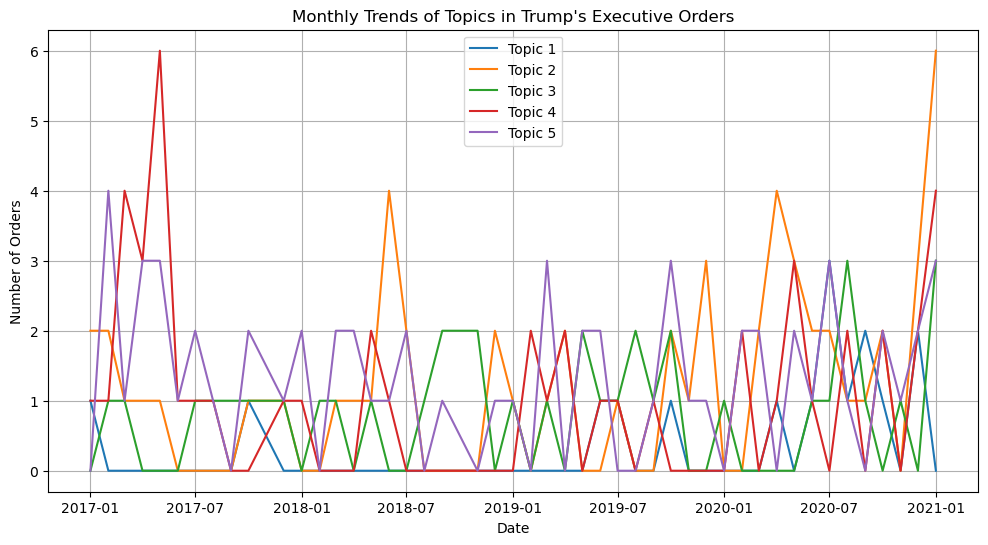

In [ ]:
# monthly trends of topics for trump's executive orders from the year of 2017 to 2022
plt.figure(figsize=(12, 6))
for topic in topic_trends_monthly.columns:
    plt.plot(topic_trends_monthly.index, topic_trends_monthly[topic], label=topic)
plt.title("Monthly Trends of Topics in Trump's Executive Orders")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Forecast for a specific topic 
# topic # could change 
model = ARIMA(topic_trends_monthly['Topic 1'], order=(1, 1, 1)) 
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)
print(forecast)


47    1.003142
48    0.893729
49    0.905663
50    0.904361
51    0.904503
52    0.904488
53    0.904489
54    0.904489
55    0.904489
56    0.904489
57    0.904489
58    0.904489
Name: predicted_mean, dtype: float64


c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xgygr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

now we extract the publication date from data to monthly basis and assign the published executive orders with the topic number from one to five which could give us better idea of the trend of topic in month. Then we adopt arima model again to predict how topic might appear again in the future term. From the result, for example, we could see the preidicted trend of topic 1 in 2025. In Jan 2025, Trump might publish one order related with topic 1 Healthcare and Access and might publsied about 0.9 order in average in the rest of eleven months on 2025. 

I attempted to use the Google Trends API to gauge public interest in the generated topics. However, the API couldn’t retrieve time-varying data for each topic’s keywords, so I’ll set this approach aside for now and consider it for future work. Here’s a summary of what I’ve done so far.

First, I cleaned the dataset using insights from a word cloud and identified five key topics specifically related to Trump’s executive orders. I then applied ARIMA to forecast the potential volume of executive orders he might issue in his upcoming term. Additionally, I analyzed topic trends on a monthly basis, which provides insight into the topics Trump emphasized in the past. This historical trend analysis helps predict the likelihood of future executive orders focusing on similar topics.

While integrating real-time public interest data from Google Trends would add more depth to the analysis, offering a dynamic view of future topic relevance, it remains an area to explore in future work.